# Train data Preprocessing

In [78]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt


In [79]:
# variates
ed = pd.read_csv('./data/train_data/ed_train_raw.csv') # education DataFrame
hh = pd.read_csv('./data/train_data/hh_train_raw.csv') # household DataFrame

# labels
poverty = pd.read_csv('./data/train_data/poverty_train_raw.csv') # poverty/labels


# Education data

In [80]:
ed.head(3)

,psu,hh,idcode,q01,q02,q03,q04,q05,q06,q07,...,Q57,Q58,Q59,Q60,Q61,Q62,Q63,Q64,Q65,Q66
0,2,8,3,1,1,1,2.0,3.0,3.0,2.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,2.0
1,3,8,4,1,1,1,2.0,2.0,2.0,0.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,2.0
2,6,5,3,1,1,1,2.0,3.0,3.0,0.0,...,2.0,NaN,2.0,NaN,2.0,NaN,NaN,2.0,NaN,4.0


In [81]:
def preprocess_df(df, suffix:str):
    ## merge first three columns into psu_hh_idcode identifier
    uids = df['psu'].astype(str) + "_"  + df['hh'].astype(str) + "_" + df['idcode'].astype(str) 
    df = df.drop(columns=['psu', 'hh', 'idcode'])

    ## Capitalize all Q's in column names. Add ED or HH to the beginning of each variable
    df.columns = [suffix + "_" + col.capitalize() for col in df.columns]

    # Insert uid as first column, lowercase, no prefix.
    df.insert(0, 'uid', uids)

    return df

ed = preprocess_df(ed, 'ED')
hh = preprocess_df(hh, 'HH')

# Remove useless variates
 
See Explorations.ipynb for more details on variable selection.

In [82]:
# These variables are set in Explorations.ipynb
%store -r hh_useless_columns
%store -r ed_useful_columns


In [83]:

hh = hh.drop(columns=hh_useless_columns)
ed = ed[ed_useful_columns]


# Filter data based on avaliable labels 
Not all uids have a reported poverty score assigned to them, so we cannot train our models on all of the data. 


In [84]:

### Convert poverty scores from one hot encoding [0,1] to a single column [1-10]
for i in range(1,11):
    col = 'subjective_poverty_'+ str(i)
    poverty.loc[poverty[col]==1, 'poverty_score'] = i

poverty['uid'] = poverty['psu_hh_idcode']
poverty = poverty[['uid', 'poverty_score']]


In [85]:
# select only eduction and household data for those uids that have reported a poverty score.

ed = ed[ed['uid'].isin(poverty['uid'])]
ed = ed.merge(poverty[['uid', 'poverty_score']], on='uid', how='left')

hh = hh[hh['uid'].isin(poverty['uid'])]
hh = hh.merge(poverty[['uid', 'poverty_score']], on='uid', how='left')

# Rename variates for interpretability

* Plus some basic feature engineering.


In [86]:

# EDUCATION DATA

ed['read'] =  ed['ED_Q01']
ed['write'] = ed['ED_Q02']

ed['attended_school'] = ed['ED_Q03'] # from 1 yes, 2 No

ed['highest_school_lvl'] = ed['ED_Q04'] #  categories=list(range(1, 11))) # 8yrs - PhD

ed['preschool'] = ed['ED_Q07'] # years

# Merge
ed['now_enrolled'] = ed['ED_Q08'] #.eq(1)
ed['now_attending'] = ed['ED_Q09'] # from 1 yes, 2 No
ed['past_enrolled'] = ed['ED_Q14'] # from 1 yes, 2 No
ed['past_attending'] = ed['ED_Q15'] # from 1 yes, 2 No

# Merge
ed['now_not_attend_reason'] = ed['ED_Q10'] #    categories=list(range(1, 13)))
ed['now_not_enroll_reason'] = ed['ED_Q11'] # categories=list(range(1, 14)))
ed['past_not_attend_reason'] = ed['ED_Q16'] # categories=list(range(1, 13)))
ed['past_not_enroll_reason'] = ed['ED_Q17'] # categories=list(range(1, 14)))


ed['finish_school_age'] = ed['ED_Q18'] 

ed['public_private_school'] = ed['ED_Q23'] # categories=list(range(1, 4)))

ed['school_transportation_time'] = ed['ED_Q26'] # in hours, truncate minutes 

ed['school_transportation_vehicle'] = ed['ED_Q28'] # categories=list(range(1, 7)))

ed['school_transportation_cost'] = ed['ED_Q29'] 

ed['school_expenses'] = ed['ED_Q41'] 

named_variates = [
    'uid',
    'read',
    'write',
    'attended_school','highest_school_lvl',
    'preschool',
    'now_enrolled','now_attending','past_enrolled', 'past_attending',
    'now_not_attend_reason','now_not_enroll_reason','past_not_attend_reason','past_not_enroll_reason',
    'finish_school_age',
    'public_private_school',
    'school_transportation_time','school_transportation_vehicle',
    'school_transportation_cost','school_expenses',
    'poverty_score'
]

ed = ed[named_variates]

In [87]:
ed.head(3)

,uid,read,write,attended_school,highest_school_lvl,preschool,now_enrolled,now_attending,past_enrolled,past_attending,...,now_not_enroll_reason,past_not_attend_reason,past_not_enroll_reason,finish_school_age,public_private_school,school_transportation_time,school_transportation_vehicle,school_transportation_cost,school_expenses,poverty_score
0,441_2_3,1,1,1,2.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,140000.0,4.0
1,647_7_1,1,1,1,2.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,75000.0,4.0
2,756_4_1,1,1,1,2.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,100000.0,6.0


# Processing NaNs and variable selection
* You shuold take care of the NaNs before any feature engineering, even .eq(1)

In [88]:
# variables with no NaNs
assert(len(ed.loc[ed['read'].isna()]) == 0)
assert(len(ed.loc[ed['write'].isna()]) == 0)
assert(len(ed.loc[ed['attended_school'].isna()]) == 0)

# Convert to boolean
ed.loc[:, 'read'] = ed['read'].eq(1)
ed.loc[:, 'write'] = ed['write'].eq(1)
ed.loc[:, 'attended_school'] = ed['attended_school'].eq(1)


/var/folders/21/wpdrdb153rgcw7h7qz_vrd_40000gn/T/ipykernel_91384/1920975587.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ed.loc[:, 'read'] = ed['read'].eq(1)
/var/folders/21/wpdrdb153rgcw7h7qz_vrd_40000gn/T/ipykernel_91384/1920975587.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ed.loc[:, 'write'] = ed['write'].eq(1)
/var/folders/21/wpdrdb153rgcw7h7qz_vrd_40000gn/T/ipykernel_91384/1920975587.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompa

# VAR:Attended_school 
This variate reveals the possibility of splitting the data into two groups:

1. Attended school (All variates avaliable to predict poverty score)
2. Did not attend school (Only read and write variates avaliable to predict poverty score)
    * 139 is a small group though, so we could just remove all of them. 

In [89]:
# Evidence for the above claims
not_atended = ed.loc[ed['attended_school'].eq(False)]['uid']
no_school = ed.loc[ed['highest_school_lvl'].isna()]['uid']
assert(not_atended.equals(no_school))
assert(len(no_school) == 139)

In [90]:
# Let's see how many people we are interested in predicting have not attended school
test_data = pd.read_csv('./data/test_data/edu_test.csv')
# 39 is the same number as before
test_data_did_not_attend = len(test_data.loc[test_data['q03'].eq(2)])
assert(test_data_did_not_attend == 39)
total_rows = test_data.shape[0]
print(f"Total percentage of people who did not attend school in test data: {test_data_did_not_attend / total_rows}")


Total percentage of people who did not attend school in test data: 0.02923538230884558


In [91]:
ed.shape

(5334, 21)

Based on this, we can remove the 139 people who did not attend school from the training data for now. Evaluate choice later.

In [92]:
condition = ed['attended_school'].eq(True)
ed = ed[condition]
hh = hh[hh['uid'].isin(ed['uid'])]

In [93]:
# attended school now becomes redundant
ed = ed.drop(columns=['attended_school'])


# VAR:highest_school_lvl
Supposed to be a categorical variable with values 1-11.
Training data range is only 1-10.

In [94]:
ed['highest_school_lvl'].describe()

count    5195.000000
mean        2.171126
std         1.763821
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: highest_school_lvl, dtype: float64

In [95]:
# No NaNs to worry about
assert(len(ed.loc[ed['highest_school_lvl'].isna()]) == 0)
# No 11 categories 
assert(len(ed.loc[ed['highest_school_lvl'].eq(11)]) == 0)

In [96]:
# All we need to do is convert to categorical
CATEGORIES = 10
ed['highest_school_lvl'] = pd.Categorical(ed['highest_school_lvl'], 
                                          categories=list(range(1, CATEGORIES)))


# VAR:preschool

In [97]:
# No NaNs to worry about
assert(len(ed.loc[ed['preschool'].isna()]) == 0)

In [98]:
ed['preschool'].describe()

count    5195.000000
mean        0.529355
std         0.814562
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         4.000000
Name: preschool, dtype: float64

# VARS:
* now_enrolled
* now_attending
* past_enrolled
* past_attending
* now_not_attend_reason
* now_not_enroll_reason
* past_not_attend_reason
* past_not_enroll_reason

# At the very least, we have the following dependencies: 
* now_enrolled -> now_not_enroll_reason==null
* now_attending -> now_not_attend_reason==null
* past_enrolled -> past_not_enroll_reason==null
* past_attending -> past_not_attend_reason==null

So we can merge now_enrolled and now_not_enroll_reason into a single categorical variable.

In [ ]:
# VAR:now_attending

assert(len(ed.loc[ed['now_enrolled'].isna()]) == 0)


### Claim: 
* now_attending==Null <-> now_enrolled==False
* If you didn't enroll, you obviously can't attend.

What can we do with this knowledge?



In [ ]:
# Proof 
not_enrolled = ed.loc[ed['now_enrolled'].eq(2)]
attending_no_ans = ed.loc[ed['now_attending'].isna()]
assert(attending_no_ans.equals(not_enrolled))

So now I am wondering when exactly are enrollemnt and attendance different?

* The asnwer is not that often. Only 8 students enrolled but did no attend in the test data. 
* We can further see that they all have the same reason for not attending: Reason #2: "Not interested" HUH! 

In [112]:
# Proof
enroll_did_not_attend = ed['now_enrolled'].eq(1) & ed['now_attending'].eq(2)

ed.loc[enroll_did_not_attend, ['uid', 'now_enrolled', 'now_attending', 'now_not_attend_reason']]

,uid,now_enrolled,now_attending,now_not_attend_reason
290,502_4_1,1.0,2.0,2.0
293,830_9_1,1.0,2.0,2.0
502,284_6_1,1.0,2.0,2.0
537,369_2_2,1.0,2.0,2.0
876,829_7_2,1.0,2.0,2.0
1000,771_2_2,1.0,2.0,2.0
1082,491_6_1,1.0,2.0,2.0
4194,77_5_1,1.0,2.0,2.0


If these group pf students was larger and if they had modal reason for not attending realting to poverty, then we could justify the value of having a "now_enrolled" and a "now_attending" variables. But since neither is true, we can just use "now_enrolled" as a proxy for "now_attending".

In [113]:
# Making some assumptions for past_attending, past_not_attend_reason, past_not_enroll_reason
# Can evaluate/tune later.
ed = ed.drop(columns=['now_attending', 'past_attending', 'now_not_attend_reason', 'past_not_attend_reason'])


Now let's see how now_enrolled and past_enrolled are related

In [125]:
# Both have no NaNs to worry about
assert(len(ed.loc[ed['now_enrolled'].isna()])==0)
assert(len(ed.loc[ed['past_enrolled'].isna()])==0)

# Check when they differ and the reason why
group3 = ed.loc[ed['now_enrolled'].ne(ed['past_enrolled']), 
       ['uid', 
        'now_enrolled', 'past_enrolled',
        'now_not_enroll_reason', 'past_not_enroll_reason',
        'poverty_score']]
group3

,uid,now_enrolled,past_enrolled,now_not_enroll_reason,past_not_enroll_reason,poverty_score
16,767_6_7,2.0,1.0,13.0,NaN,4.0
26,486_7_2,2.0,1.0,13.0,NaN,3.0
31,747_3_3,2.0,1.0,13.0,NaN,4.0
34,175_8_3,2.0,1.0,13.0,NaN,3.0
290,502_4_1,1.0,2.0,NaN,2.0,3.0
293,830_9_1,1.0,2.0,NaN,2.0,5.0
502,284_6_1,1.0,2.0,NaN,2.0,6.0
537,369_2_2,1.0,2.0,NaN,2.0,4.0
876,829_7_2,1.0,2.0,NaN,2.0,6.0
1000,771_2_2,1.0,2.0,NaN,2.0,2.0


Again, this is such a small group that we can just remove them. 
You can evaluate the impact of this decision on the predictive accuracy later.
The alternative would be to split into another group.

If you want to evaluate the validity of this decision, without looing at predictive accuracy directly, you could look at the distribution of poverty scores wihtin this group.

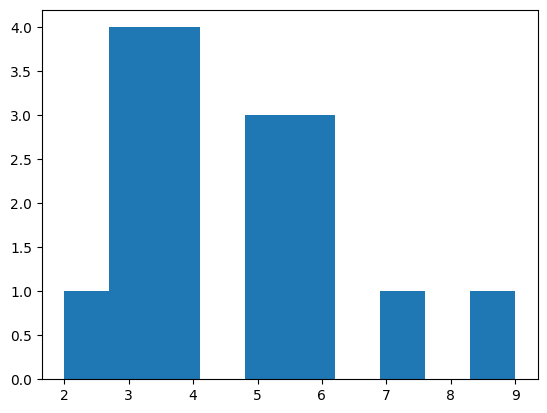

In [123]:
plt.hist(group3['poverty_score'])
plt.show()


There is no glaringly obious difference in the poverty scores of these two groups, but this is probability, so you coudl argue that more people who attended but did not enroll are more likely to be poor.

We can see that now_enrolled=2 and past_enrolled=1 all have the same reason for not enrolling now, 
Reason 13: "Completed studies"

In [ ]:




ed['now_enrolled'] = ed['ED_Q08'].eq(1)
ed['now_attending'] = ed['ED_Q09'].eq(1) # from 1 yes, 2 No
ed['past_enrolled'] = ed['ED_Q14'].eq(1) # from 1 yes, 2 No
ed['past_attending'] = ed['ED_Q15'].eq(1) # from 1 yes, 2 No

# Merge
ed['now_not_attend_reason'] = pd.Categorical(ed['ED_Q10'], categories=list(range(1, 13)))
ed['now_not_enroll_reason'] = pd.Categorical(ed['ED_Q11'], categories=list(range(1, 14)))
ed['past_not_attend_reason'] = pd.Categorical(ed['ED_Q16'], categories=list(range(1, 13)))
ed['past_not_enroll_reason'] = pd.Categorical(ed['ED_Q17'], categories=list(range(1, 14)))


# Final processing recipe



In [99]:

# EDUCATION DATA

ed['literate'] = ed['ED_Q01'].eq(1) & ed['ED_Q02'].eq(1)  # read and write

ed['attended_school'] = ed['ED_Q03'].eq(1) # from 1 yes, 2 No

ed['highest_school_lvl'] = pd.Categorical(ed['ED_Q04'], categories=list(range(1, 11))) # 8yrs - PhD

ed['preschool'] = ed['ED_Q07'] # years

# Merge
ed['now_enrolled'] = ed['ED_Q08'].eq(1)
ed['now_attending'] = ed['ED_Q09'].eq(1) # from 1 yes, 2 No
ed['past_enrolled'] = ed['ED_Q14'].eq(1) # from 1 yes, 2 No
ed['past_attending'] = ed['ED_Q15'].eq(1) # from 1 yes, 2 No

# Merge
ed['now_not_attend_reason'] = pd.Categorical(ed['ED_Q10'], categories=list(range(1, 13)))
ed['now_not_enroll_reason'] = pd.Categorical(ed['ED_Q11'], categories=list(range(1, 14)))
ed['past_not_attend_reason'] = pd.Categorical(ed['ED_Q16'], categories=list(range(1, 13)))
ed['past_not_enroll_reason'] = pd.Categorical(ed['ED_Q17'], categories=list(range(1, 14)))


ed['finish_school_age'] = ed['ED_Q18'] 

ed['public_private_school'] = pd.Categorical(ed['ED_Q23'], categories=list(range(1, 4)))

# Consolidate hours and minutes recordings into a single variable
ed['school_transportation_time'] = ed['ED_Q26'].apply(lambda hrs : hrs * 60) +  ed['ED_Q27'] 

ed['school_transportation_vehicle'] = pd.Categorical(ed['ED_Q28'], categories=list(range(1, 7)))

ed['school_transportation_cost'] = ed['ED_Q29'] 

ed['school_expenses'] = ed['ED_Q41'] 

named_variates = [
    'uid',
    'literate','attended_school','highest_school_lvl',
    'preschool',
    'now_enrolled','now_attending','past_enrolled', 'past_attending',
    'now_not_attend_reason','now_not_enroll_reason','past_not_attend_reason','past_not_enroll_reason',
    'finish_school_age',
    'public_private_school',
    'school_transportation_time','school_transportation_vehicle',
    'school_transportation_cost','school_expenses',
    'poverty_score'
]

ed = ed[named_variates]

KeyError: 'ED_Q01'

In [20]:

# HEALTH DATA

hh['sex'] = hh['HH_Q02'] 
hh['family_role'] = pd.Categorical(hh['HH_Q03'], categories=list(range(1, 15)))

hh['age'] = hh['HH_Q05y'] # truncate to years, ignore months.

hh['marital_status'] = pd.Categorical(hh['HH_Q06'], categories=list(range(1, 6)))


hh['spouse_lives'] = hh['HH_Q07'].eq(1)

hh['time_away'] = hh['HH_Q09'] # 1-12 months 


# Moms
hh['lives_with_mom'] = hh['HH_Q11'].eq(1)

hh.loc[hh['HH_Q13']=='DK', 'HH_Q13'] = None # "Dont know" is a category
hh['moms_education'] = pd.Categorical(hh['HH_Q13'], categories=list(range(1, 11)))

hh['mom_alive'] = hh['HH_Q14'].eq(1) 

# Dad
hh['lives_with_dad'] = hh['HH_Q17'].eq(1)

hh.loc[hh['HH_Q19']=='DK', 'HH_Q19'] = None # "Dont know" is a category
hh['dad_education'] = pd.Categorical(hh['HH_Q19'], categories=list(range(1, 11)))

hh['dad_alive'] = hh['HH_Q20'].eq(1)

hh = hh.drop(columns=['HH_Q02', 'HH_Q03', 'HH_Q05y', 'HH_Q05m', 'HH_Q06', 'HH_Q07',
       'HH_Q09', 'HH_Q10', 'HH_Q11', 'HH_Q13', 'HH_Q14', 'HH_Q15', 'HH_Q16',
       'HH_Q17', 'HH_Q19', 'HH_Q20', 'HH_Q21', 'HH_Q22'])


# Variable Selection


# Is student?

In [23]:
# enrollment and attendance past and present:

ed['now_attending'] = ed['now_attending'].fillna(ed['now_enrolled'])
ed['past_attending'] = ed['past_attending'].fillna(ed['past_enrolled'])

# We only care if they attended at least one year in the past 2.
attended = ed['now_attending'].eq(1) | ed['past_attending'].eq(1)  # NaN values mean they are NOT students
ed.loc[attended, 'is_student'] = True
ed.loc[~attended, 'is_student'] = False

ed =  ed.drop(columns=['now_enrolled', 'past_enrolled', 'past_attending', 'now_attending'])


# absence reasons:

In [25]:

ed.loc[ed['now_not_attend_reason'] == 13, 'now_not_attend_reason'] = 14
ed.loc[ed['past_not_attend_reason'] == 13, 'past_not_attend_reason'] = 14

# We have situations where someone enrolls but does not attend.
# We don't have situations when someone who did not enroll attends. 
# So use attend as base truth and fill some of the NaNs with enrolled.
ed['now_not_attend_reason'] = ed['now_not_attend_reason'].fillna(ed['now_not_enroll_reason'])
ed['past_not_attend_reason'] = ed['past_not_attend_reason'].fillna(ed['past_not_enroll_reason'])

ed = ed.drop(columns=['now_not_enroll_reason', 'past_not_enroll_reason'])

ed['now_not_attend_reason'] = ed['now_not_attend_reason'].fillna(14) #"other"
ed['past_not_attend_reason'] = ed['past_not_attend_reason'].fillna(14) # other

In [26]:
dummies = pd.get_dummies(ed['now_not_attend_reason'], prefix='not_attend_reason1', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)

dummies = pd.get_dummies(ed['past_not_attend_reason'], prefix='not_attend_reason2', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)



In [27]:
ed = ed.drop(columns=['now_not_attend_reason', 'past_not_attend_reason'])

# Highest School lvl

In [36]:
ed['highest_school_lvl'].describe()

count    5195.000000
mean        2.171126
std         1.763821
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: highest_school_lvl, dtype: float64

In [37]:
Q4_education_mapping = [0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7] # just gives the same values to same degrees (no matter where they were studied)
ed['highest_school_lvl'] =  ed['highest_school_lvl'].apply(lambda indx : indx if pd.isna(indx) else Q4_education_mapping[int(indx)])

## fill out NaN values with standarized mean
av = ed['highest_school_lvl'].mean()
ed['highest_school_lvl'] = ed['highest_school_lvl'].fillna(round(av, 2))


In [38]:
ed['highest_school_lvl'].describe()

count    5334.000000
mean        1.998500
std         1.388792
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: highest_school_lvl, dtype: float64

# Preschool?

In [40]:
ed['preschool'] = ed['preschool'].fillna(0)

# finish_school_age, younger_19
 don't make sense. we will have the age from hh

In [42]:
av = round(ed['finish_school_age'].mean(), 2)
ed['finish_school_age'] = ed['finish_school_age'].fillna(av)

# public_private_school
Q23: Is the school that [Name] attend in public or private?

* PUBLIC	= 1
* PRIVATE RELIGIOUS	= 2
* PRIVATE NON-RELIGIOUS	= 3

I like this ordering because, apparently, "Non-religious private schools are more expensive than religious private schools on average"

NaN replacement: 
AVERAGE because average assigns a more conservative value to NaN. A zero on this new scale is still the 25th quantile so it is biased towards poverty ya know.

But indicator variables have the potential to model the relatinsip better than by increases in 1... 
**everytime you want to make up a scale think of this: can I do it bettern than a machine?**

In [44]:
ed['public_private_school'] = ed['public_private_school'].fillna(1) # no data avaliable
dummies = pd.get_dummies(ed['public_private_school'], prefix='school_type', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)


In [45]:
ed = ed.drop(columns=['public_private_school'])

# Transportation

Just transform into indicator variables!!!!! see what happens 

In [47]:
dummies = pd.get_dummies(ed['school_transportation_vehicle'], prefix='transport', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)


In [48]:
ed = ed.drop(columns=['school_transportation_vehicle'])

In [50]:
av = int(ed['school_transportation_time'].mean())
ed['school_transportation_time'] = ed['school_transportation_time'].fillna(round(av,2))

# because they are kids so they probably feel like the cost is 0
ed['school_transportation_cost'] = ed['school_transportation_cost'].fillna(0)

# school_expenses

In [52]:
av = int(ed['school_expenses'].mean())
ed['school_expenses'] = ed['school_expenses'].fillna(round(av,2))


# Household data

In [55]:
# leave sex as is
hh['sex'] = hh['sex'].eq(1)


# family role

In [57]:
dummies = pd.get_dummies(hh['family_role'], prefix='fam_role', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)


In [58]:
# hh['frequency'] = hh.groupby(['family_role', 'poverty_score'])['family_role'].transform('count')

# # Normalize the frequencies for color mapping
# max_freq = hh['frequency'].max()
# hh['normalized_frequency'] = hh['frequency'] / max_freq

# # Scatterplot
# plt.scatter(
#     hh['family_role'], 
#     hh['poverty_score'], 
#     c=hh['normalized_frequency'],  # Use normalized frequency for color
#     cmap='Blues',                  # Choose a colormap
#     edgecolor='black', 
#     s=100, 
#     alpha=0.8
# )



# marital_status 
just make it into 5 indicator variables. 



In [60]:
dummies = pd.get_dummies(hh['marital_status'], prefix='marital_status', drop_first=True)
ed = pd.concat([ed, dummies], axis=1)


In [61]:
# get rid of both
hh = hh.drop(columns=['marital_status', 'family_role'])

In [62]:
hh['lives_with_partner'] = hh['spouse_lives'].eq(1)
hh = hh.drop(columns=['spouse_lives'])

# time away is good

In [64]:
hh['lives_with_parent'] = hh['lives_with_mom'].eq(1) | hh['lives_with_dad'].eq(1)
hh = hh.drop(columns=['lives_with_mom', 'lives_with_dad'])

In [65]:
hh['parents_education'] = (hh['moms_education'] + hh['dad_education']) / 2
ave = hh['parents_education'].mean()
hh['parents_education'] = hh['parents_education'].fillna(round(ave,2))

hh = hh.drop(columns=['moms_education', 'dad_education'])

In [66]:
# parents alive 
hh['mom_alive'] = hh['mom_alive'].eq(1)
hh['dad_alive'] = hh['dad_alive'].eq(1)
hh['mom_alive'] = hh['mom_alive'].apply(lambda boo: 1 if boo else 0)
hh['dad_alive'] = hh['dad_alive'].apply(lambda boo: 1 if boo else 0)

hh['num_parents_alive'] = hh['mom_alive'] + hh['dad_alive']
hh = hh.drop(columns=['mom_alive', 'dad_alive'])

# DONE

In [68]:
df = pd.merge(ed, hh, on='uid', how='inner')  # Use 'inner' join by default


In [69]:
df = df.drop(columns=['poverty_score_x'])
df.to_csv('X_TRAIN.csv', index=False)